__1.1  批量自动生成拓扑优化后处理数据集程序：__

In [1]:
import scipy.io as io
import os 
import glob
import numpy as np

class Generate_dataset():
    def __init__(self, docu_path, save_data_path, save_label_path, nelx, nely, nelz):
        self.docu_path = docu_path
        self.data_path = glob.glob(os.path.join(self.docu_path, '*.mat'))
        self.save_data_path = save_data_path
        self.save_label_path = save_label_path
        self.nelx = nelx
        self.nely = nely
        self.nelz = nelz

    def load_data(self):
        for t in range(len(self.data_path)):
            print('读取第',t,'个文件完毕')
            data = io.loadmat(self.data_path[t])
            ndarray_data = data['ans']
            print('文件维度为：',ndarray_data.shape)
            ndarray_data = np.pad(ndarray_data, ((self.nely - ndarray_data.shape[0], 0),
                                                 (self.nelx - ndarray_data.shape[1], 0),
                                                 (self.nelz - ndarray_data.shape[2], 0)))
            #保存输入数据集
            ndarray_data = ndarray_data[np.newaxis, :, :, :]
            np.save(os.path.join(self.save_data_path,'%d.npy'%(t)), ndarray_data)
            #保存标签数据集
            label_data = np.squeeze(ndarray_data, axis=0)
            for i in range(label_data.shape[0]):
                for j in range(label_data.shape[1]):
                    for k in range(label_data.shape[2]):
                        if label_data[i][j][k] > 0.5:
                            label_data[i][j][k] = 1
                        else:
                            label_data[i][j][k] = 0
            for i in range(label_data.shape[0]):
                for j in range(label_data.shape[1]):
                    for k in range(label_data.shape[2]):
                        if label_data[i][j][k] > 0.5:
                            label_data[i][j][k] = 1
                        else:
                            label_data[i][j][k] = 0
            label_data = label_data[np.newaxis, :, :, :]
            np.save(os.path.join(self.save_label_path, '%d.npy'%(t)),label_data)
test = Generate_dataset('../../../dataset/Matlab_Files/data_mat/', '../../../dataset/dataset/input/', '../../../dataset/dataset/label/', 120, 120, 120)
test.load_data()


读取第 2 个文件完毕
文件维度为： (15, 30, 30)
读取第 3 个文件完毕
文件维度为： (60, 60, 4)


__1.2  数据批量化3D可视化：__

读入第 0 个模型输入数据：
读入第 1 个模型输入数据：
读入第 2 个模型输入数据：
读入第 3 个模型输入数据：
读入第 0 个模型标签数据：
读入第 1 个模型标签数据：
读入第 2 个模型标签数据：
读入第 3 个模型标签数据：


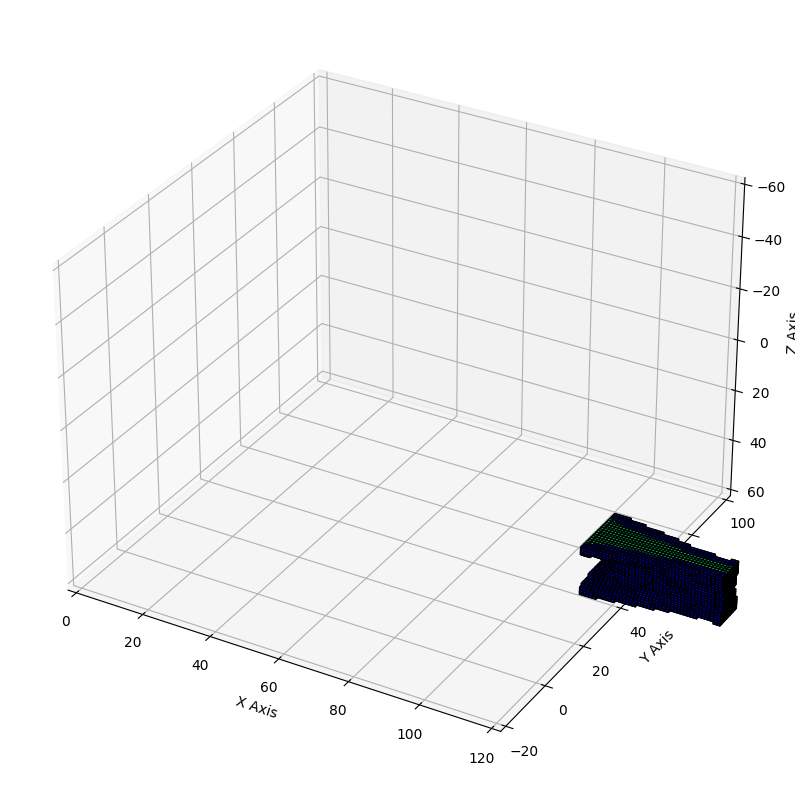

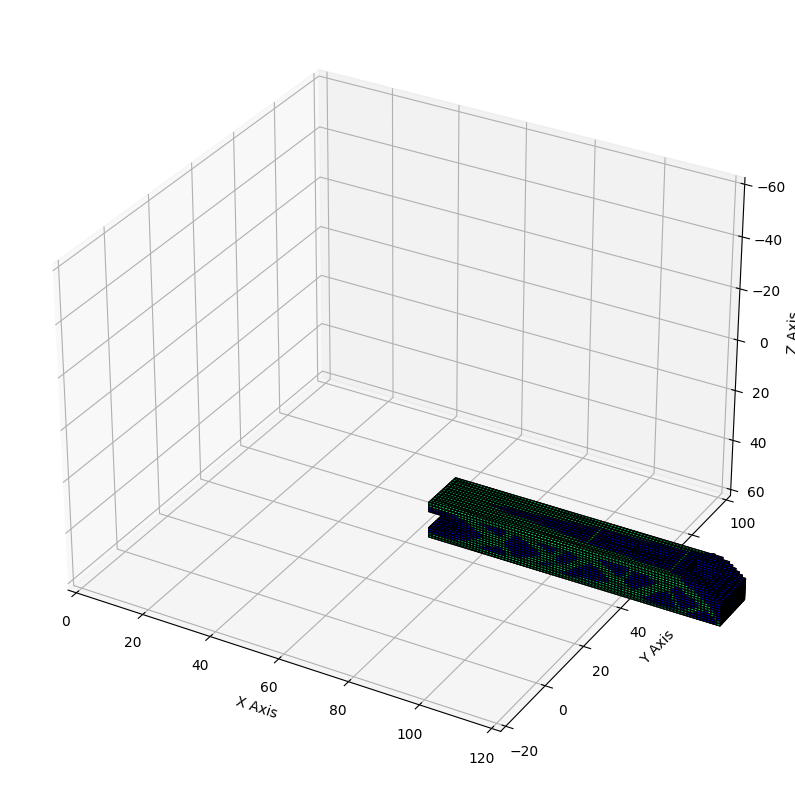

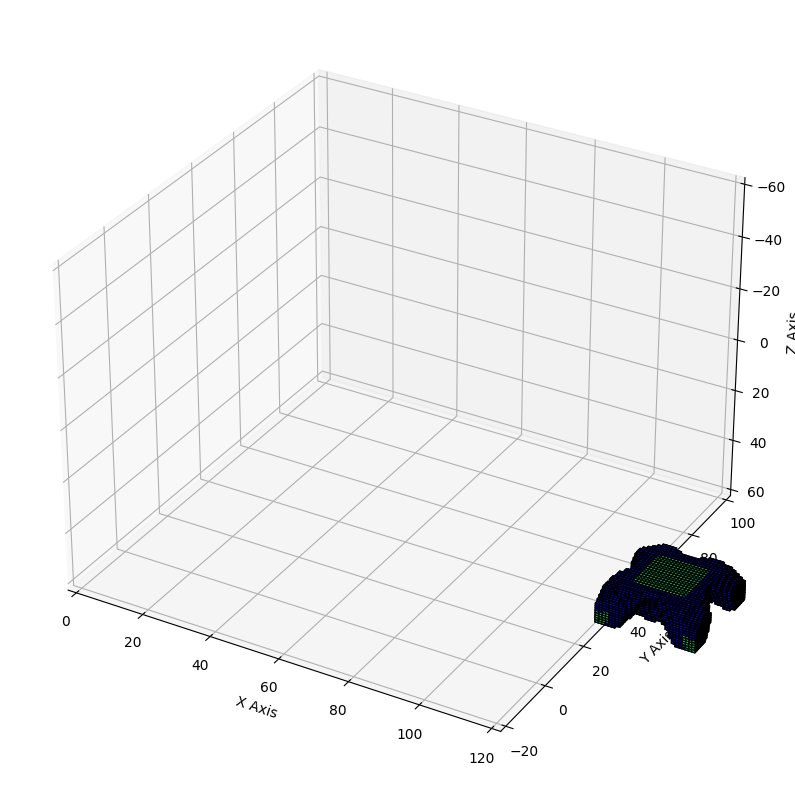

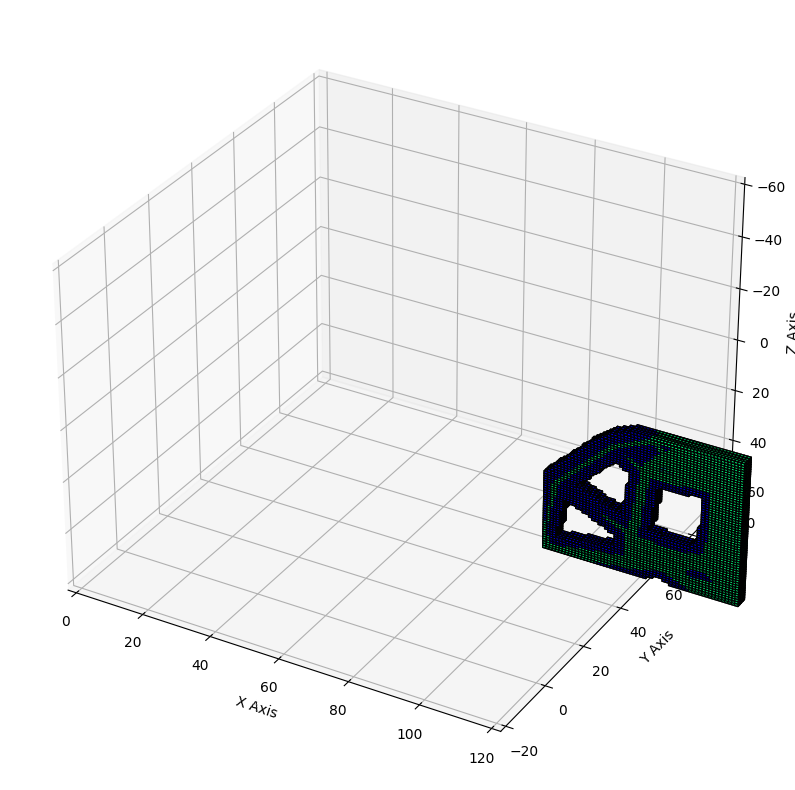

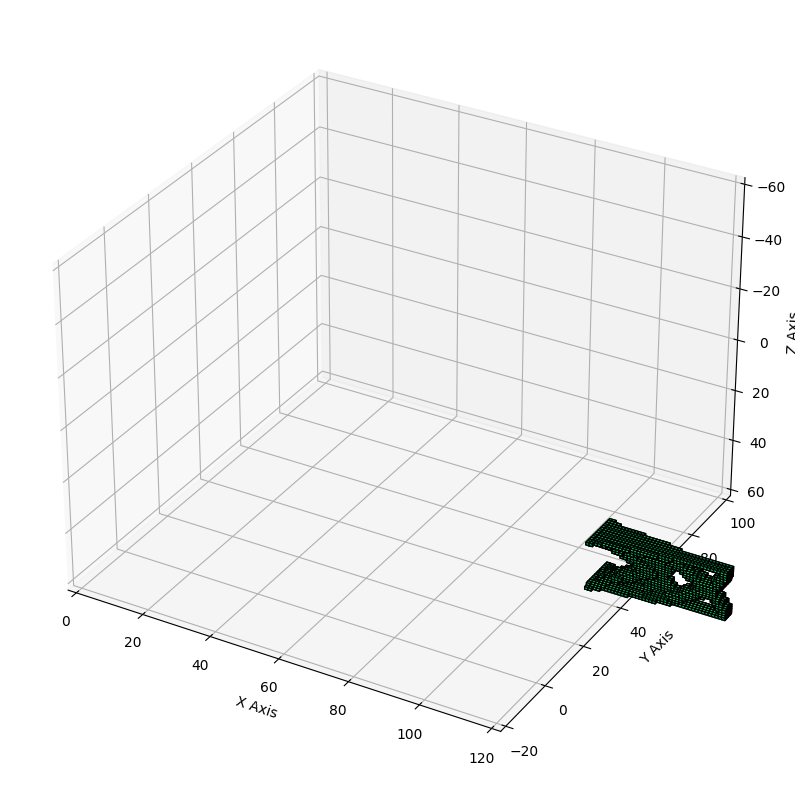

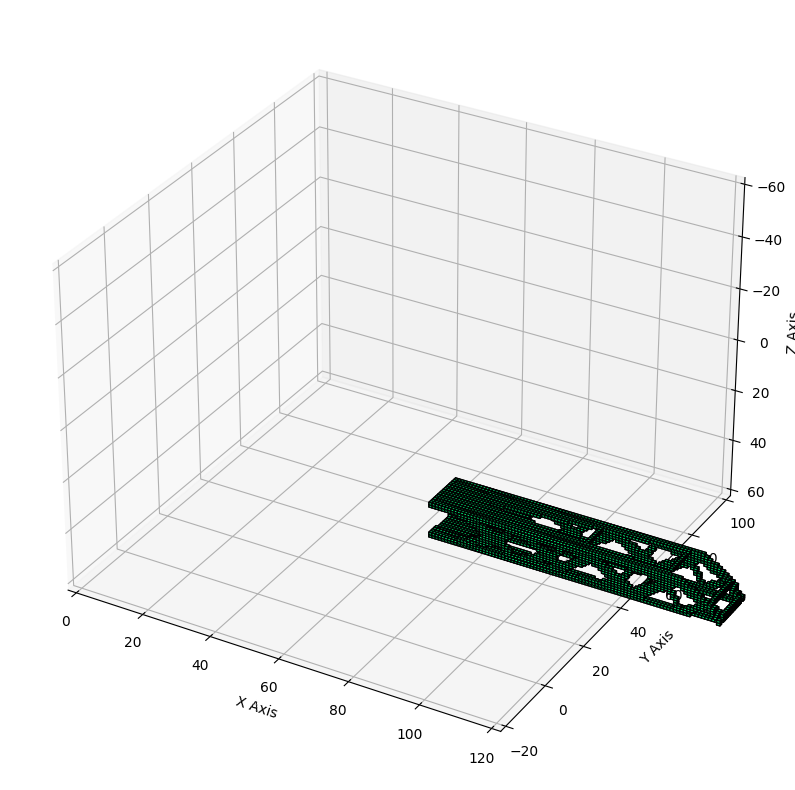

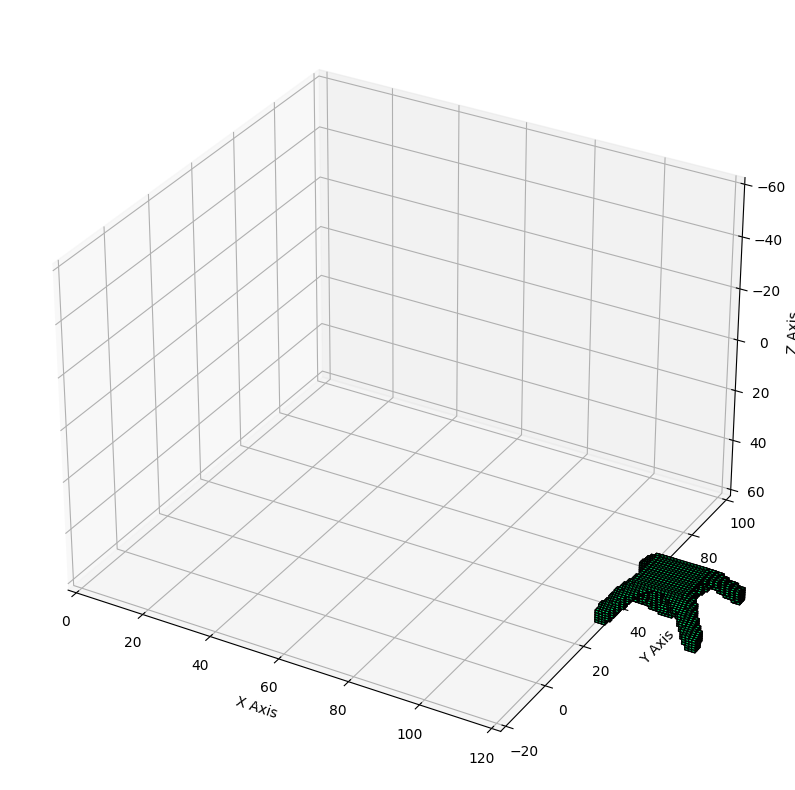

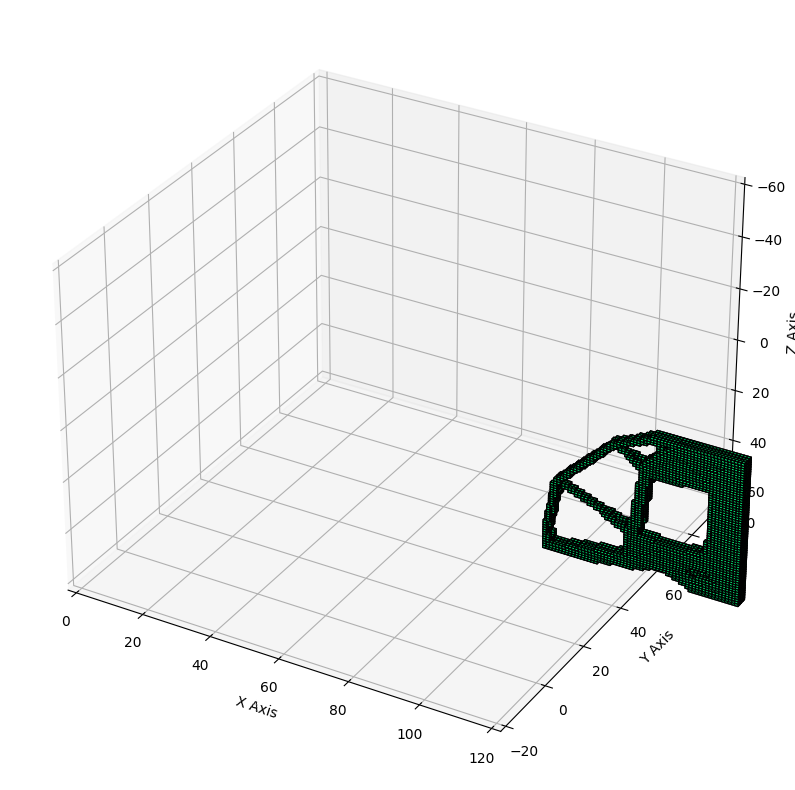

In [2]:
import numpy as np 
import os 
import glob
import matplotlib.pyplot as plt


class model_vision():
    def __init__(self, docu_path):
        self.docu_path = docu_path
        self.data_path = glob.glob(os.path.join(self.docu_path, 'input/*.npy'))

    def data_vision(self):
        for i in range(len(self.data_path)):
            print('读入第',i,'个模型输入数据：')
            data = np.load(self.data_path[i])
            data = np.squeeze(data, axis=0)

            data = data.transpose(1, 2, 0)   #(x, z, y)
            mycolormap = plt.get_cmap('winter')
            data_max=data.max()
            relativevalue=np.round(data/data_max,1)
            colorsvalues=mycolormap(relativevalue)


            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(projection='3d')
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
            ax.set_xlim(0, 120)   #设置每个轴的刻度大小
            ax.set_ylim(-20, 100)
            ax.set_zlim(60, -60)
            ax.voxels(data, facecolors=colorsvalues, edgecolor='k', shade=False)
    
    
    def label_vision(self):
        
        for i in range(len(self.data_path)):
            self.label_path = self.data_path[i].replace('input', 'label')
            print('读入第',i,'个模型标签数据：')
            label = np.load(self.label_path)
            label = np.squeeze(label, axis=0)

            label = label.transpose(1, 2, 0)   #(x, z, y)
            mycolormap = plt.get_cmap('winter')    #设置颜色表（colormap）将一系列数值映射到一张colormap上，不同数值表示不同的颜色
            label_max=label.max()
            relativevalue=np.round(label/label_max,1)
            colorsvalues=mycolormap(relativevalue)


            fig = plt.figure(figsize=(10, 10))
            fig.patch.set_alpha(0.5)
            ax = fig.add_subplot(projection='3d')
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
            ax.set_xlim(0, 120)   #设置每个轴的刻度大小
            ax.set_ylim(-20, 100)
            ax.set_zlim(60, -60)
            ax.voxels(label, facecolors=colorsvalues, edgecolor='k', shade=False)

test = model_vision('../../../dataset/dataset/')
test.data_vision()
test.label_vision()

__1.3  制作数据集__

In [3]:
import os 
import glob
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
class top_dataset(Dataset):
    def __init__(self, docu_path):
        self.docu_path = docu_path
        self.data_path = glob.glob(os.path.join(self.docu_path, 'input/*.npy'))

    def __getitem__(self, index):
        self.data_index = self.data_path[index]
        self.label_index = self.data_index.replace('input', 'label')

        #加载input数据
        data = np.load(self.data_index)
        tensor_data = torch.from_numpy(data)
        label = np.load(self.label_index)
        tensor_label = torch.from_numpy(label)
        return tensor_data, tensor_label
    
    def __len__(self):
        return len(self.data_path)
    

#此部分代码是导入数据集代码，此处用于验证制作数据集代码正确性
if __name__ == '__main__':
    top_data = top_dataset('../../../dataset/dataset/')
    print('数据个数为：',len(top_data))
    train_loader = torch.utils.data.DataLoader(dataset=top_data,
                                               batch_size=1,
                                               shuffle=True)
    
    for tensor_data, tensor_label in train_loader:
        print(tensor_data.shape)
        print(tensor_label.shape)

数据个数为： 4
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
torch.Size([1, 1, 120, 120, 120])
